In [114]:
import pandas as pd

df = pd.read_csv('./Data/combined_injury_records.csv')
df.drop(columns=['injury_category','date_il_retro', 'date_return'], inplace=True)
df

,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury
0,Robert Stephenson,1993-02-24,RP,Tommy John surgery,2024-04-30,393,31
1,Zach Neto,2001-01-31,INF,Shoulder surgery,2024-11-06,163,23
2,Anthony Rendon,1990-06-06,INF,Hip surgery,2025-02-01,240,34
3,Sam Bachman,1999-09-30,SP,Thoracic outlet syndrome,2025-02-01,107,25
4,Yoán Moncada,1995-05-27,INF,Sprained thumb (right),2025-04-09,27,29
...,...,...,...,...,...,...,...
4453,Sam Coonrod,1992-09-22,RP,Strained shoulder,2020-09-25,3,28
4454,Reyes Moronta,1993-01-06,RP,Shoulder surgery (torn labrum),2019-09-10,384,26
4455,Aramis Garcia,1993-01-12,C,Hip surgery,2020-02-06,235,27
4456,Tyler Beede,1993-05-23,SPRP,Tommy John surgery,2020-03-20,192,26


In [115]:
df.query("injury.str.contains('surgery', case=False, na=False)")

,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury
0,Robert Stephenson,1993-02-24,RP,Tommy John surgery,2024-04-30,393,31
1,Zach Neto,2001-01-31,INF,Shoulder surgery,2024-11-06,163,23
2,Anthony Rendon,1990-06-06,INF,Hip surgery,2025-02-01,240,34
8,Ben Joyce,2000-09-17,RP,Shoulder surgery (torn labrum),2025-05-14,173,24
35,Tyler Wells,1994-08-26,SP,Elbow surgery (internal brace),2024-06-17,442,29
...,...,...,...,...,...,...,...
4442,Trey Wingenter,1994-04-15,RP,Tommy John surgery,2020-07-18,72,26
4443,Kirby Yates,1987-03-25,RP,Elbow surgery (bone chips),2020-08-19,44,33
4454,Reyes Moronta,1993-01-06,RP,Shoulder surgery (torn labrum),2019-09-10,384,26
4455,Aramis Garcia,1993-01-12,C,Hip surgery,2020-02-06,235,27


In [116]:
injury_category_map = {
    'Major Surgery': r'surgery',
    'Muscle strain': r'strain',
    'Ligament sprain': r'sprain',
    'Tendon injury': r'tendon|impingement|tendinopathy',
    'Bone': r'fracture|bone|stress|bone bruise|dislocation',
    'Contusion & Impact': r'contusion|impact',
    'Skin': r'skin|cut|laceration|blister',
    'Illness': r'illness|viral|bacterial|covid|flu',
    'Discomfort & Tightness': r'spasm|tightness|discomfort|fatigue|stiffness|soreness',
    'Neurological': r'concussion|headache|nerve|thoracic outlet',
    'Imflammation': r'itis|inflammation|metatarsalgia',
    'Infection': r'infection|sepsis'
}

In [117]:
def categorize_injury(injury):
    injury_lower = str(injury).lower()
    for category, pattern in injury_category_map.items():
        if pd.Series(injury_lower).str.contains(pattern, case=False, na=False).any():
            return category
    return 'Other'

df['injury_category'] = df['injury'].apply(categorize_injury)
df = df.loc[df['injury'] != 'TBD']
df = df.loc[df['injury'] != 'Illness']

df


,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category
0,Robert Stephenson,1993-02-24,RP,Tommy John surgery,2024-04-30,393,31,Major Surgery
1,Zach Neto,2001-01-31,INF,Shoulder surgery,2024-11-06,163,23,Major Surgery
2,Anthony Rendon,1990-06-06,INF,Hip surgery,2025-02-01,240,34,Major Surgery
3,Sam Bachman,1999-09-30,SP,Thoracic outlet syndrome,2025-02-01,107,25,Neurological
4,Yoán Moncada,1995-05-27,INF,Sprained thumb (right),2025-04-09,27,29,Ligament sprain
...,...,...,...,...,...,...,...,...
4453,Sam Coonrod,1992-09-22,RP,Strained shoulder,2020-09-25,3,28,Muscle strain
4454,Reyes Moronta,1993-01-06,RP,Shoulder surgery (torn labrum),2019-09-10,384,26,Major Surgery
4455,Aramis Garcia,1993-01-12,C,Hip surgery,2020-02-06,235,27,Major Surgery
4456,Tyler Beede,1993-05-23,SPRP,Tommy John surgery,2020-03-20,192,26,Major Surgery


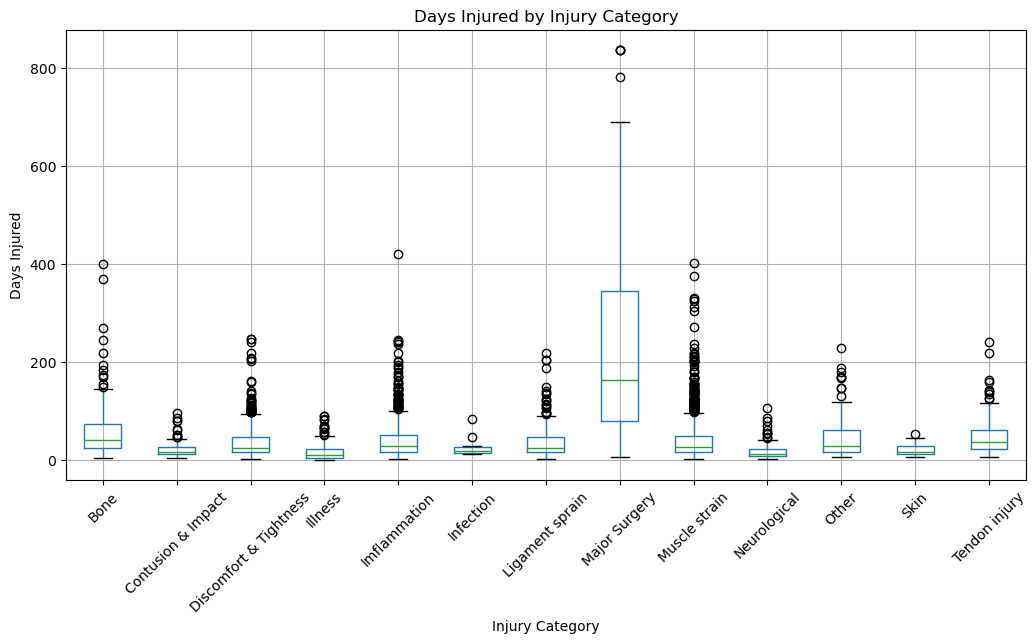

In [118]:
import matplotlib.pyplot as plt
import numpy as np

df.boxplot(column='days_injured', by='injury_category', figsize=(12, 6))
plt.title('Days Injured by Injury Category')
plt.suptitle('')
plt.xlabel('Injury Category')
plt.ylabel('Days Injured')
plt.xticks(rotation=45)
plt.show()

In [119]:
df.groupby('injury_category')['days_injured'].describe()

,count,mean,std,min,25%,50%,75%,max
injury_category,,,,,,,,
Bone,238.0,57.537815,53.251064,4.0,24.25,40.5,73.00,400.0
Contusion & Impact,117.0,22.547009,16.538094,4.0,13.00,16.0,26.00,97.0
Discomfort & Tightness,365.0,40.756164,40.073466,2.0,16.00,24.0,48.00,247.0
Illness,349.0,15.845272,15.922915,1.0,5.00,11.0,23.00,89.0
Imflammation,625.0,42.777600,41.829402,2.0,17.00,29.0,51.00,420.0
Infection,10.0,27.600000,22.192091,12.0,15.00,19.0,26.75,83.0
Ligament sprain,254.0,37.803150,35.461729,2.0,16.00,25.0,46.75,219.0
Major Surgery,557.0,211.511670,164.337908,7.0,80.00,164.0,346.00,836.0
Muscle strain,1556.0,40.781491,40.584426,2.0,17.00,27.0,49.00,402.0


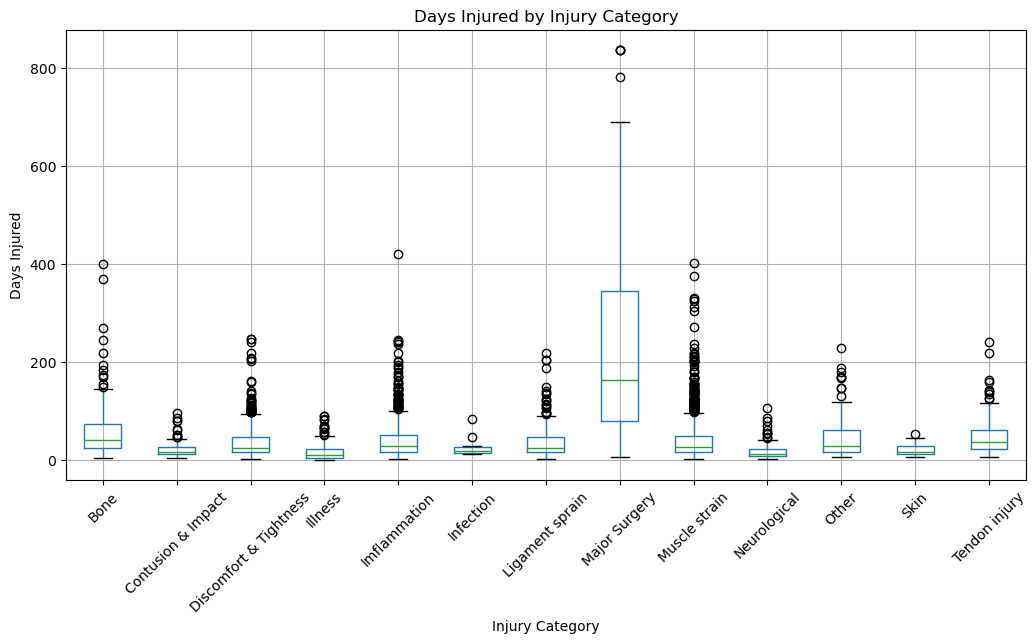

In [120]:
df.boxplot(column='days_injured', by='injury_category', figsize=(12, 6))
plt.title('Days Injured by Injury Category')
plt.suptitle('')
plt.xlabel('Injury Category')
plt.ylabel('Days Injured')
plt.xticks(rotation=45)
plt.show()



In [121]:
# divide by body parts and visualization

body_part_map = {
    'Joints' : r'shoulder|rotator cuff|scapula|teres major|thoracic|wrist|carpal|ankle|achilles|elbow|tommy john|ucl|ulnar|knee|acl|meniscus|patellar|patella',
    'Lower': r'leg|glute|gluteal|hamstring|quad|calf|shin|adductor|groin|hip|tibial|thigh',
    'Upper': r'chest|pectoral|rib|ribcage|ab|sports hernia|abdominal|oblique|abdomen|core|intercostal|costochondral',
    'Arm': r'arm|biceps|triceps|forearm|flexor',
    'Hand': r'hand|finger|nail|thumb|hamate|pinky',
    'Foot': r'|foot|toe|plantar|heel',
    'Internal': r'kidney|lung|append|col|covid|viral|flu|gastr',
    'Head/Neck' :  r'head|concussion|nasal|nose|facial|face|eye|jaw|neck|cervical',

}

In [122]:
def extract_body_part(injury):
    injury_lower = str(injury).lower()

    for body_part, sub_text in body_part_map.items():
        if pd.Series(injury_lower).str.contains(sub_text, case=False, na=False).any():
            return body_part
    return 'Other'

df['injured_part'] = df['injury'].apply(extract_body_part)
df.loc[df['injury'] == 'Thoracic outlet syndrome']


,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category,injured_part
3,Sam Bachman,1999-09-30,SP,Thoracic outlet syndrome,2025-02-01,107,25,Neurological,Joints
369,Jon Gray,1991-11-05,RP,Thoracic outlet syndrome,2025-08-16,44,33,Neurological,Joints
382,Chris Martin,1986-06-02,RP,Thoracic outlet syndrome,2025-09-25,4,39,Neurological,Joints


In [123]:
q1 = df.groupby(['injury_category', 'injured_part'])['days_injured'].transform(lambda x: x.quantile(0.25))
q3 = df.groupby(['injury_category', 'injured_part'])['days_injured'].transform(lambda x: x.quantile(0.75))

outlier = (q3 - q1) * 1.5

df = df[(df['days_injured'] < (q3 + outlier)) & (df['days_injured'] > (q1 - outlier))]

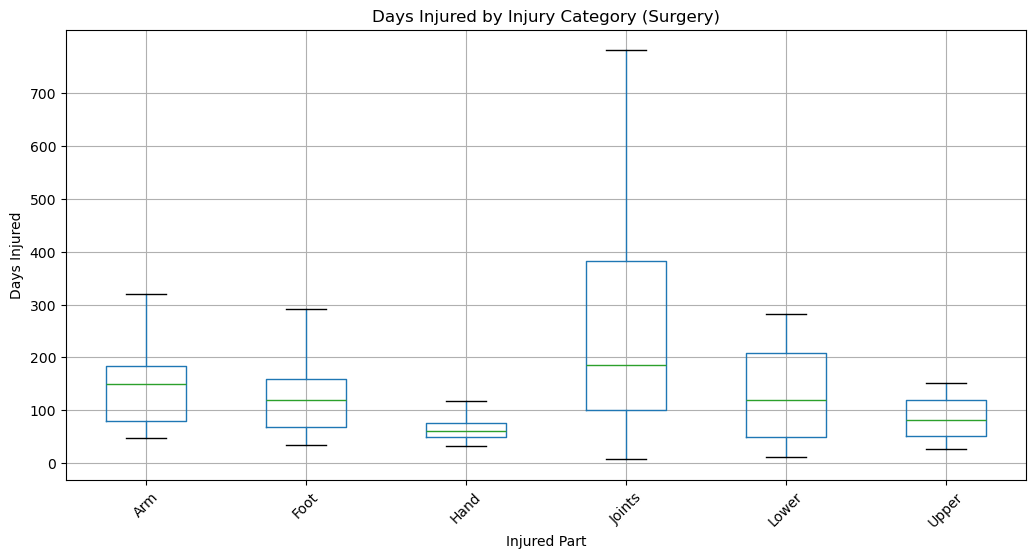

In [124]:
df_major_surgery = df.loc[df['injury_category'] == 'Major Surgery']

df_major_surgery.boxplot(column='days_injured', by='injured_part', figsize=(12, 6))
plt.title('Days Injured by Injury Category (Surgery)')
plt.suptitle('')
plt.xlabel('Injured Part')
plt.ylabel('Days Injured')
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 800, step=100))
plt.show()

In [125]:
def plot_by_injury_category(injury_category):
    df_category = df.loc[df['injury_category'] == injury_category]

    df_category.boxplot(column='days_injured', by='injured_part', figsize=(12, 6))
    plt.title(f'Days Injured by Injury Category ({injury_category})')
    plt.suptitle('')
    plt.xlabel('Injured Part')
    plt.ylabel('Days Injured')
    plt.xticks(rotation=45)
    plt.show()

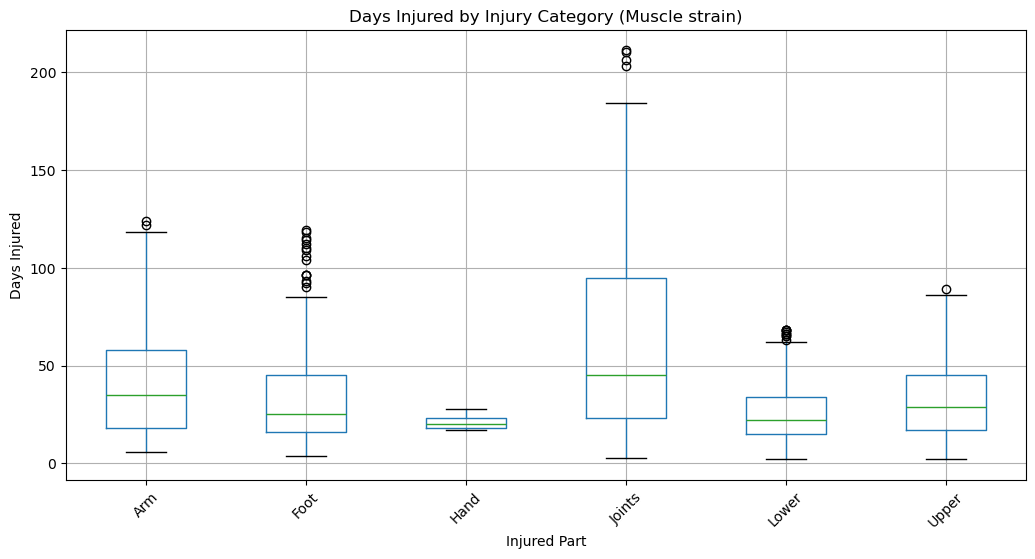

In [126]:
plot_by_injury_category('Muscle strain')


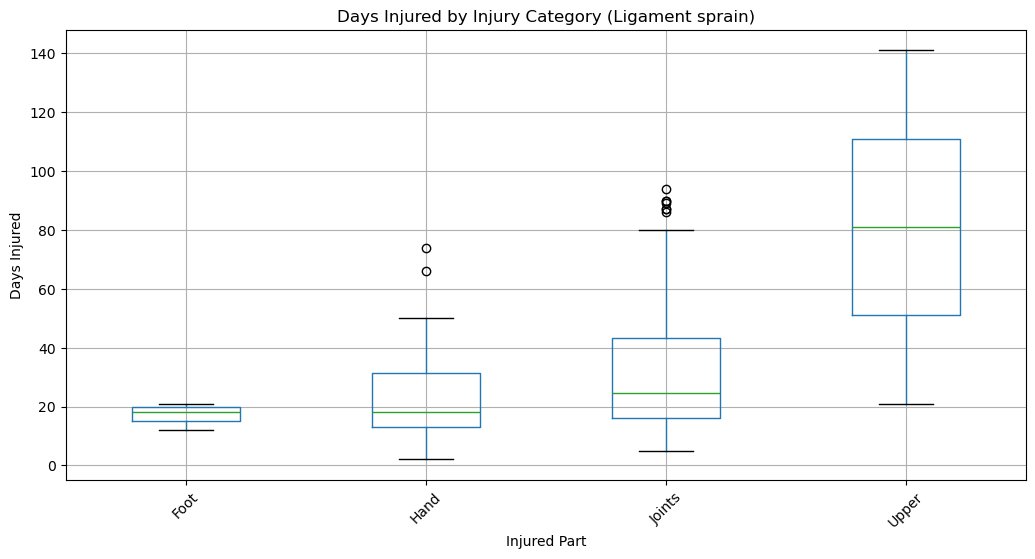

In [127]:
plot_by_injury_category('Ligament sprain')

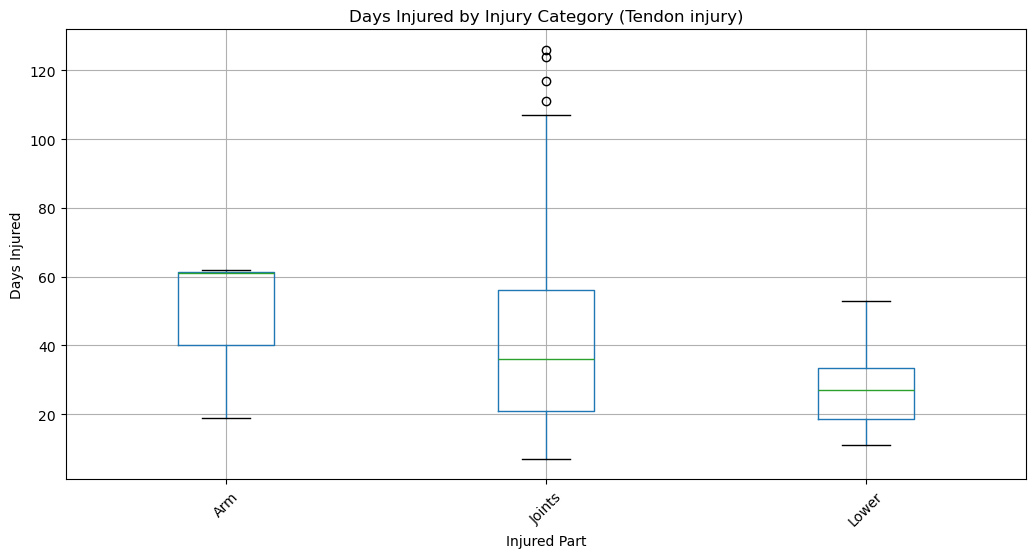

In [128]:
plot_by_injury_category('Tendon injury')

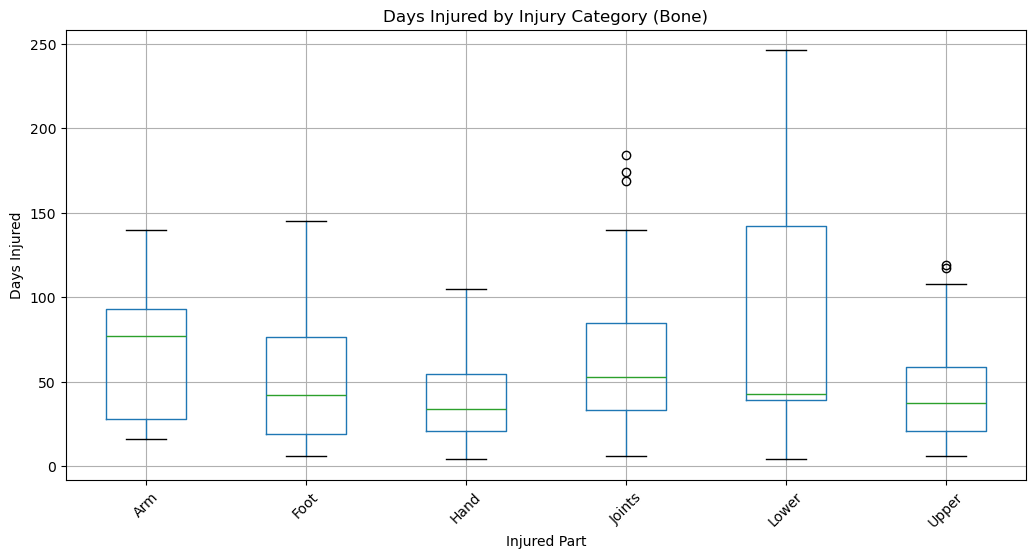

In [129]:
plot_by_injury_category('Bone')

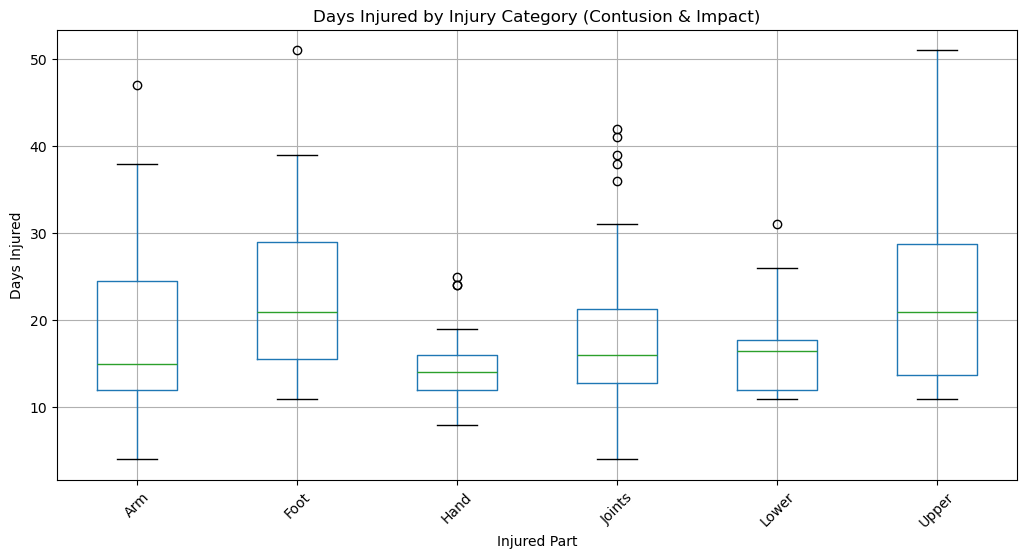

In [130]:
plot_by_injury_category('Contusion & Impact')

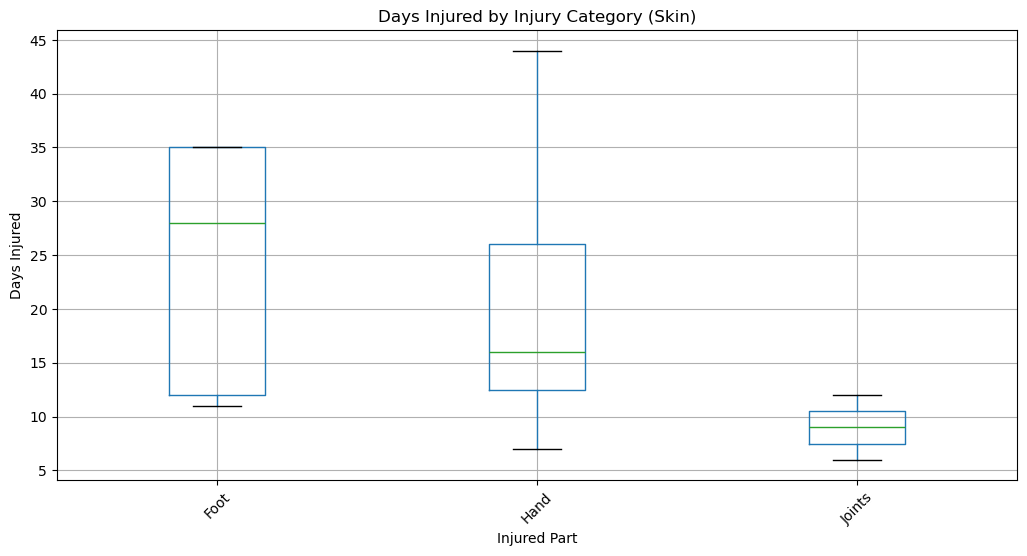

In [131]:
plot_by_injury_category('Skin')

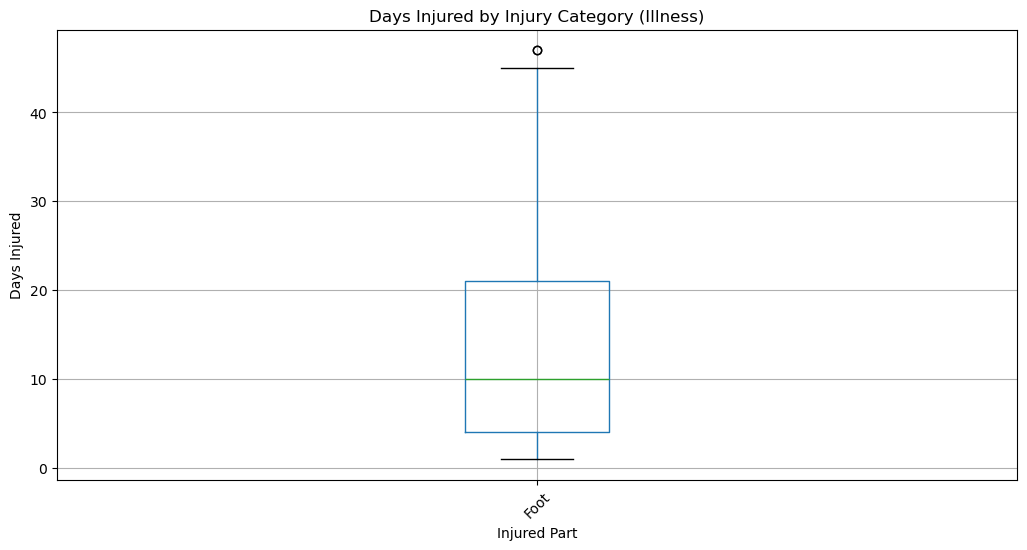

In [132]:


plot_by_injury_category('Illness')



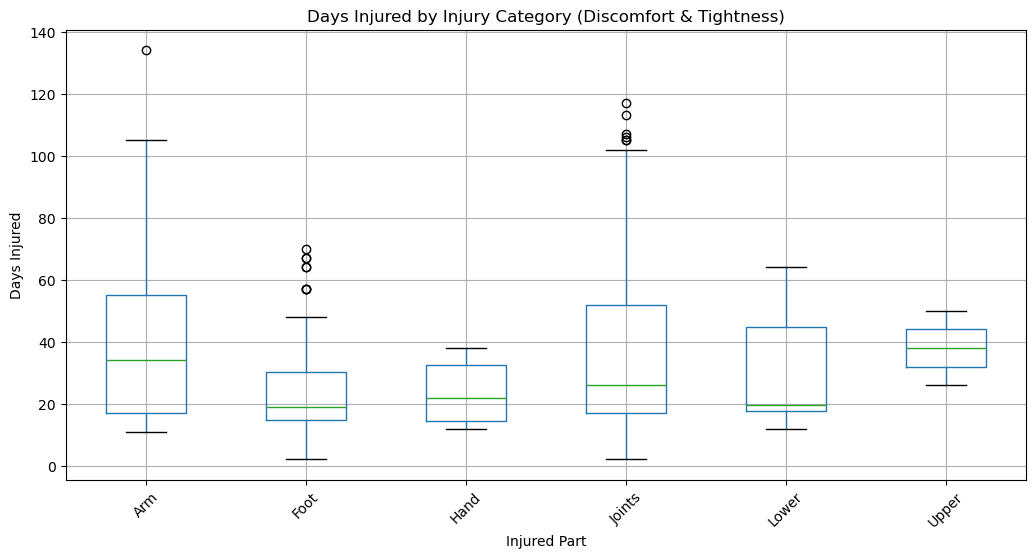

In [133]:
plot_by_injury_category('Discomfort & Tightness')

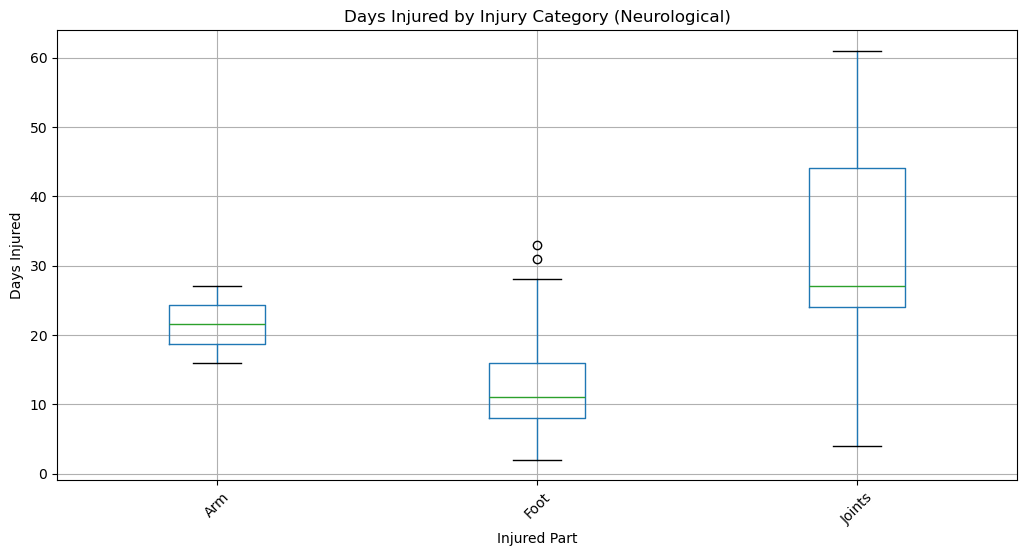

In [134]:
plot_by_injury_category('Neurological')


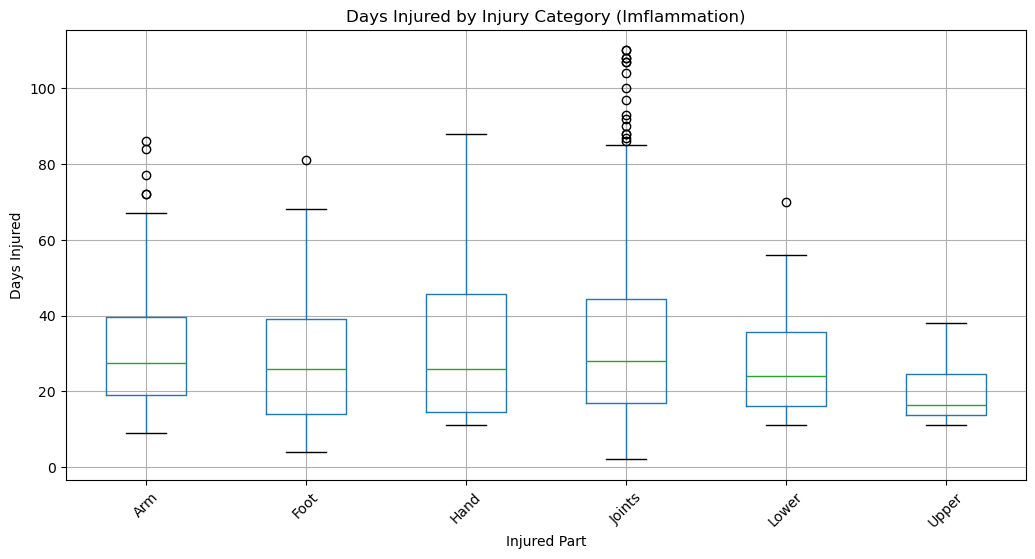

In [135]:
plot_by_injury_category('Imflammation')

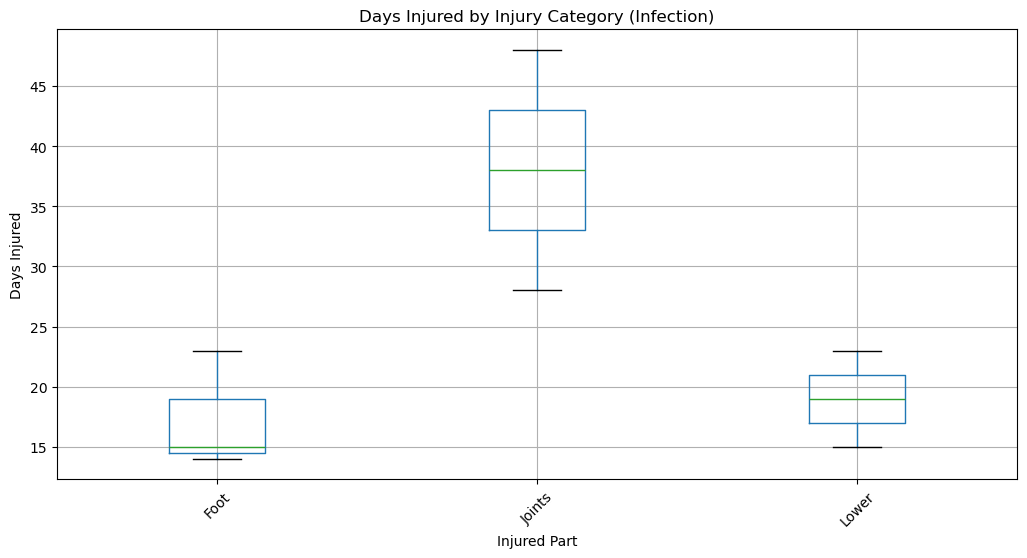

,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category,injured_part
242,Christian Vázquez,1990-08-21,C,Shoulder infection,2025-08-05,48,34,Infection,Joints
896,Tyler O'Neill,1995-06-22,OF,Calf infection,2024-08-02,15,29,Infection,Lower
1123,Ryan Pepiot,1997-08-21,SP,Knee infection,2024-07-20,28,26,Infection,Joints
1489,Austin Hays,1995-07-05,OF,Kidney infection,2024-09-01,23,29,Infection,Foot
1973,Garrett Cooper,1990-12-25,INF,Inner ear infection,2023-04-30,14,32,Infection,Foot
2414,Aroldis Chapman,1988-02-28,RP,Leg infection,2022-08-27,23,34,Infection,Lower
4171,Rougned Odor,1994-02-03,INF,Eye infection,2020-08-25,15,26,Infection,Foot


In [136]:
plot_by_injury_category('Infection')

df[df.injury_category == 'Infection']

In [137]:
def plot_by_injury_category_pos(injury_category):
    df_category = df.loc[df['injury_category'] == injury_category]

    df_category.boxplot(column='days_injured', by='pos', figsize=(12, 6))
    plt.title(f'Days Injured by Injury Category ({injury_category})')
    plt.suptitle('')
    plt.xlabel('Position')
    plt.ylabel('Days Injured')
    plt.xticks(rotation=45)
    plt.show()

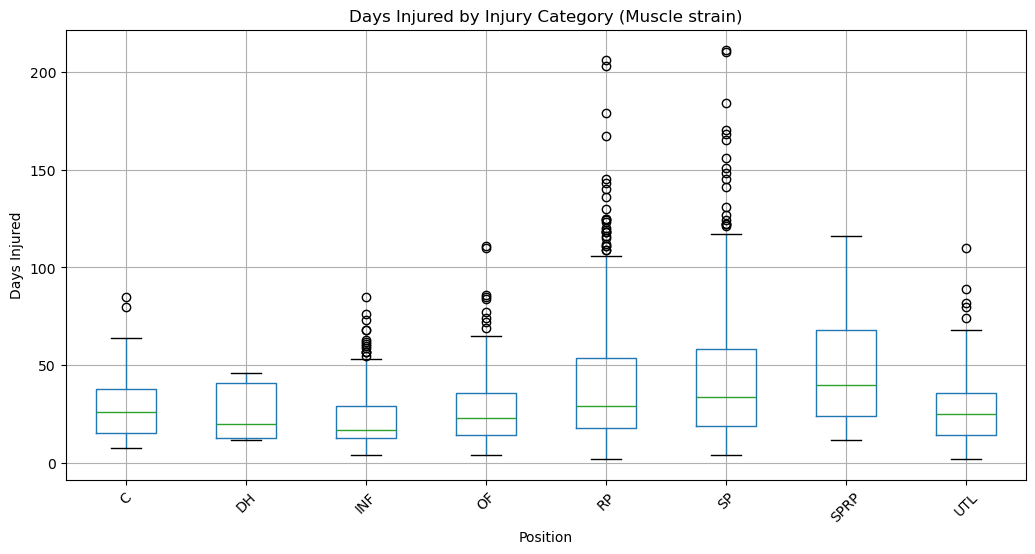

,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category,injured_part


In [138]:
plot_by_injury_category_pos("Muscle strain")

df[df.pos == 'P'][df[df.pos == 'P'].injury_category == 'Muscle strain'].sort_values(by='days_injured')



In [139]:
def plot_by_injured_part(injured_part):
    df_category = df.loc[df['injured_part'] == injured_part]

    df_category.boxplot(column='days_injured', by='injury_category', figsize=(12, 6))
    plt.title(f'Days Injured by Injured Part ({injured_part})')
    plt.suptitle('')
    plt.xlabel('Injury Category')
    plt.ylabel('Days Injured')
    plt.xticks(rotation=45)
    plt.show()

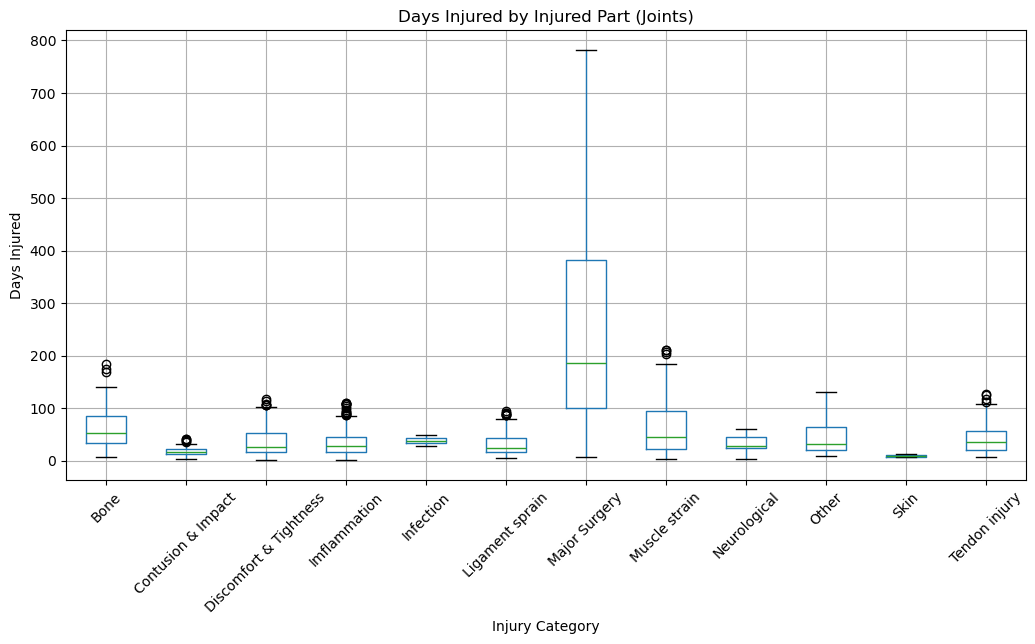

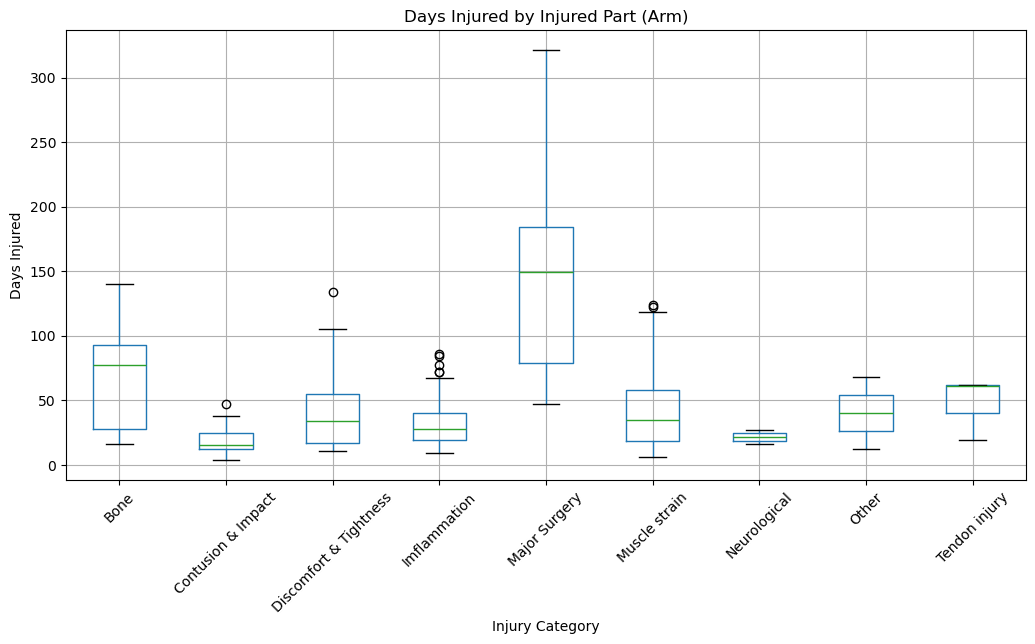

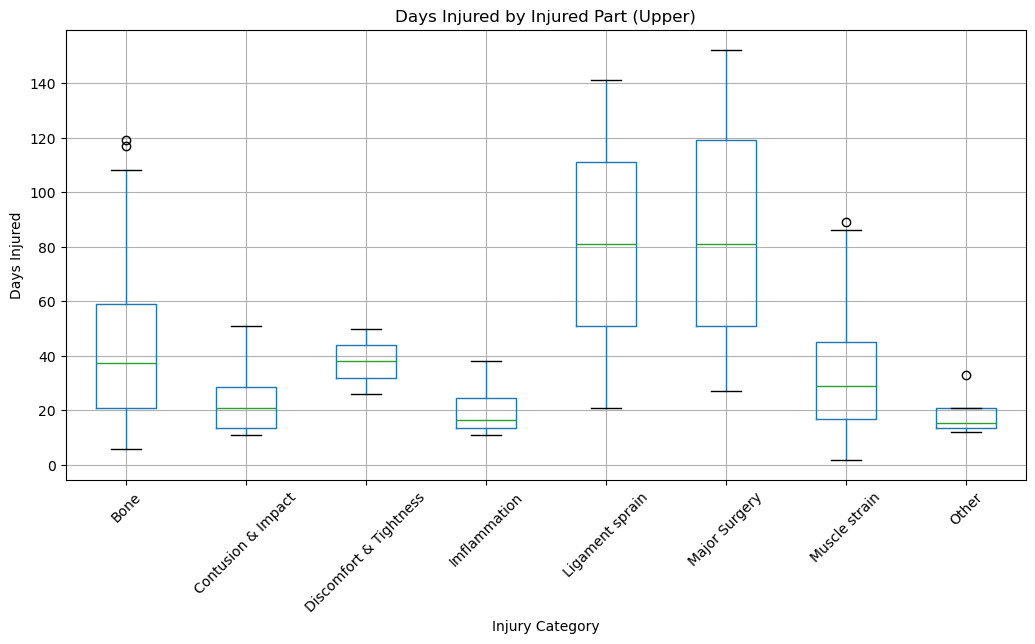

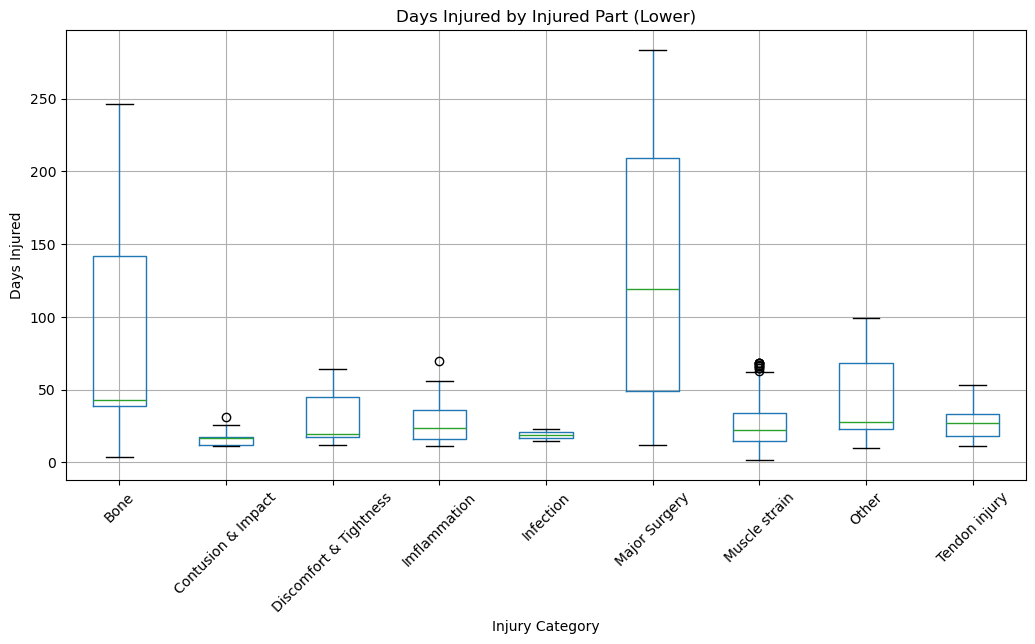

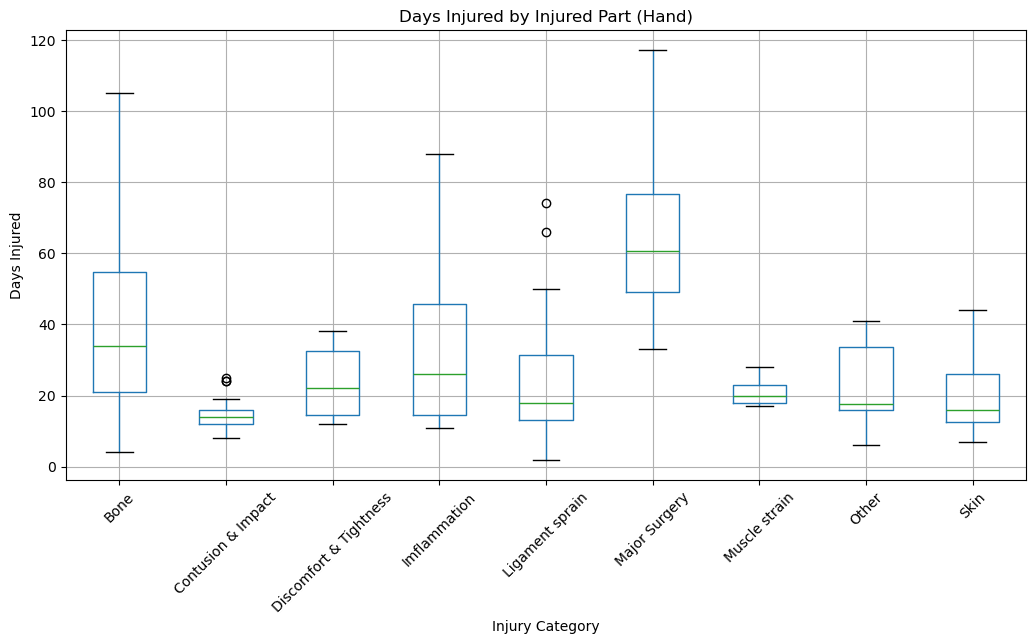

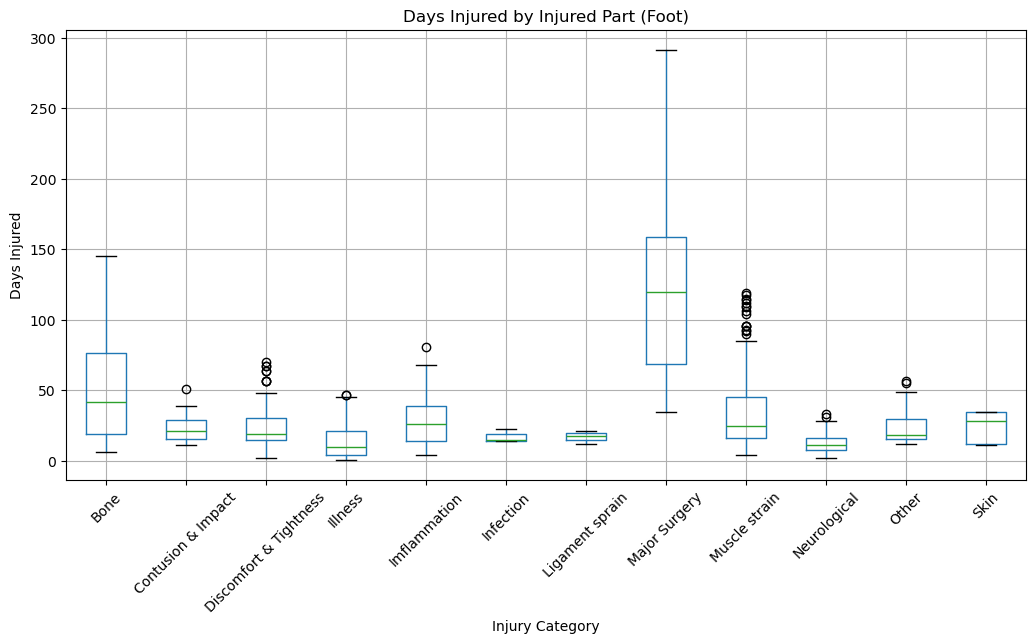

In [140]:
'''
body_part_map = {
    'Shoulder': r'shoulder|rotator cuff|scapula|teres major|thoracic',
    'Wrist': r'wrist|carpal',
    'Back': r'back|lat|\bdisc\b|spine|lumbar',
    'Lower': r'leg|glute|gluteal|hamstring|quad|calf|shin|adductor|groin|hip|tibial|thigh',
    'Ankle': r'ankle|achilles',
    'Foot': r'foot|toe|plantar|heel',
    'Hand': r'hand|finger|nail|thumb|hamate|pinky',
    'Arm': r'arm|biceps|triceps|forearm|flexor',
    'Elbow': r'elbow|tommy john|ucl|ulnar',
    'Upper': r'chest|pectoral|rib|ribcage|ab|sports hernia|abdominal|oblique|abdomen|core|intercostal|costochondral',
    'Knee': r'knee|acl|meniscus|patellar|patella',
    'Head': r'head|concussion|nasal|nose|facial|face|eye|jaw',
    'Neck': r'neck|cervical',
    'Internal': r'kidney|lung|append|col|covid|viral|flu|gastr'
}
'''

plot_by_injured_part('Joints')
plot_by_injured_part('Arm')
plot_by_injured_part('Upper')
plot_by_injured_part('Lower')
plot_by_injured_part('Hand')
plot_by_injured_part('Foot')


In [141]:
df = df.assign(severity = lambda x: x.days_injured > 100)


In [142]:
cond_list = [
    df['days_injured'] <= 30,
    (df['days_injured'] > 30) & (df['days_injured'] <= 60),
    (df['days_injured'] > 60)
]

choice_list = ['Mild', 'Moderate', 'Severe']

df['severity'] = np.select(cond_list, choice_list, default='Mild')
df

,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category,injured_part,severity
0,Robert Stephenson,1993-02-24,RP,Tommy John surgery,2024-04-30,393,31,Major Surgery,Joints,Severe
1,Zach Neto,2001-01-31,INF,Shoulder surgery,2024-11-06,163,23,Major Surgery,Joints,Severe
2,Anthony Rendon,1990-06-06,INF,Hip surgery,2025-02-01,240,34,Major Surgery,Lower,Severe
4,Yoán Moncada,1995-05-27,INF,Sprained thumb (right),2025-04-09,27,29,Ligament sprain,Hand,Mild
5,Mike Trout,1991-08-07,OF,Knee contusion,2025-04-30,30,33,Contusion & Impact,Joints,Mild
...,...,...,...,...,...,...,...,...,...,...
4453,Sam Coonrod,1992-09-22,RP,Strained shoulder,2020-09-25,3,28,Muscle strain,Joints,Mild
4454,Reyes Moronta,1993-01-06,RP,Shoulder surgery (torn labrum),2019-09-10,384,26,Major Surgery,Joints,Severe
4455,Aramis Garcia,1993-01-12,C,Hip surgery,2020-02-06,235,27,Major Surgery,Lower,Severe
4456,Tyler Beede,1993-05-23,SPRP,Tommy John surgery,2020-03-20,192,26,Major Surgery,Joints,Severe


<Axes: xlabel='injured_part,severity'>

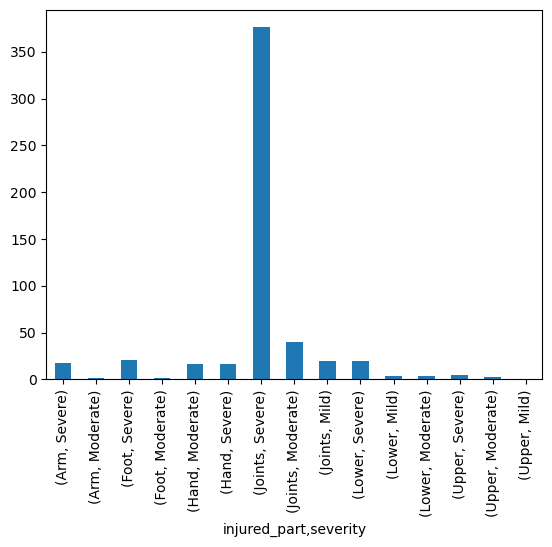

In [143]:
df_major_surgery = df.loc[df['injury_category'] == 'Major Surgery']
df_major_surgery_severity = df_major_surgery['severity'].value_counts()


df_major_surgery_group = df_major_surgery.groupby('injured_part')
df_major_surgery_severity_by_part = df_major_surgery_group['severity'].value_counts()

df_major_surgery_severity_by_part.plot(kind='bar')

In [144]:
def plot_severity_by_category(injury_category):
    df_category = df.loc[df['injury_category'] == injury_category]
    df_category_group = df_category.groupby('injured_part')
    df_category_severity_by_part = df_category_group['severity'].value_counts()
    
    df_category_severity_by_part.plot(kind='bar')

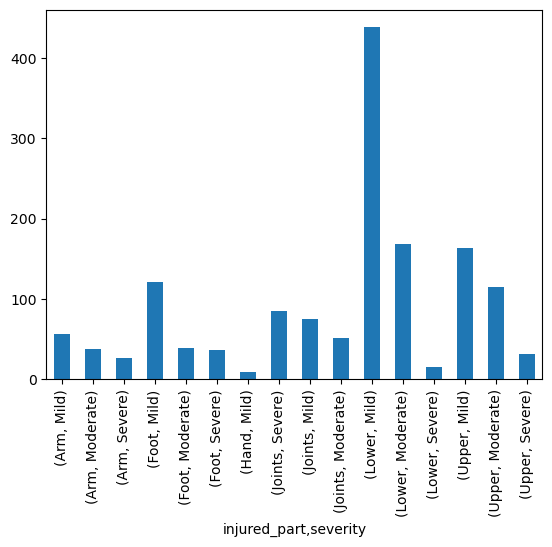

In [145]:

'''
injury_category_map = {
    'Major Surgery': r'surgery',
    'Muscle strain': r'strain',
    'Ligament sprain': r'sprain',
    'Tendon injury': r'tendon|impingement|tendinopathy',
    'Bone': r'fracture|bone|stress|bone bruise|dislocation',
    'Contusion & Impact': r'contusion|impact',
    'Skin': r'skin|cut|laceration|blister',
    'Illness': r'illness|viral|bacterial|covid|flu',
    'Discomfort & Tightness': r'spasm|tightness|discomfort|fatigue|stiffness|soreness',
    'Neurological': r'concussion|headache|nerve|thoracic outlet',
    'Imflammation': r'itis|inflammation|metatarsalgia',
    'Infection': r'infection|sepsis'
}
'''

plot_severity_by_category("Muscle strain")
 

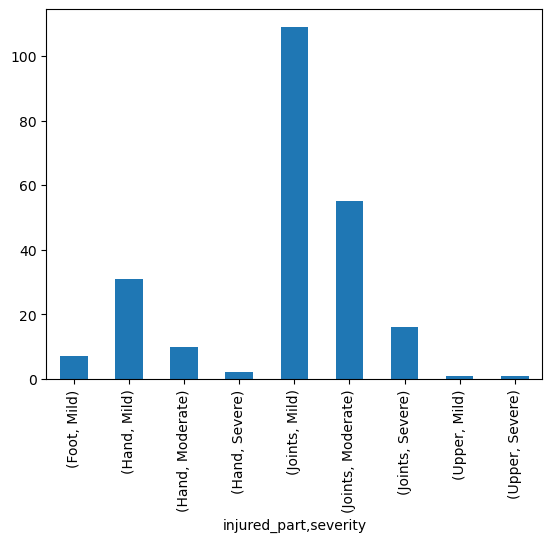

In [146]:
plot_severity_by_category('Ligament sprain')


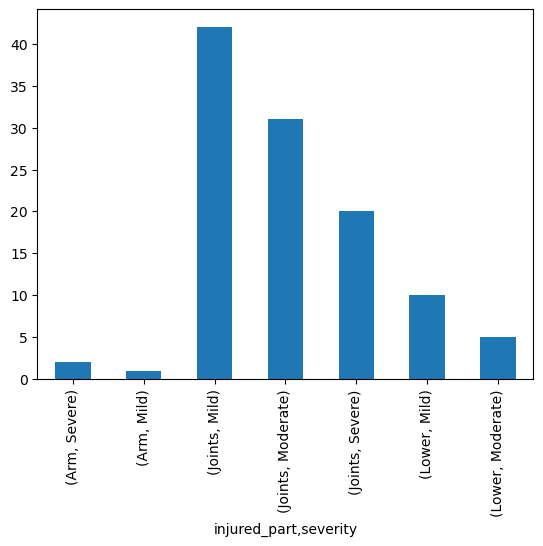

In [147]:
plot_severity_by_category('Tendon injury')
 

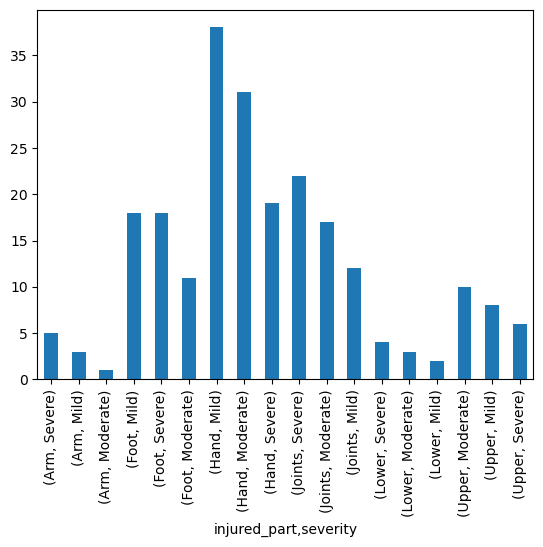

In [148]:
plot_severity_by_category('Bone')


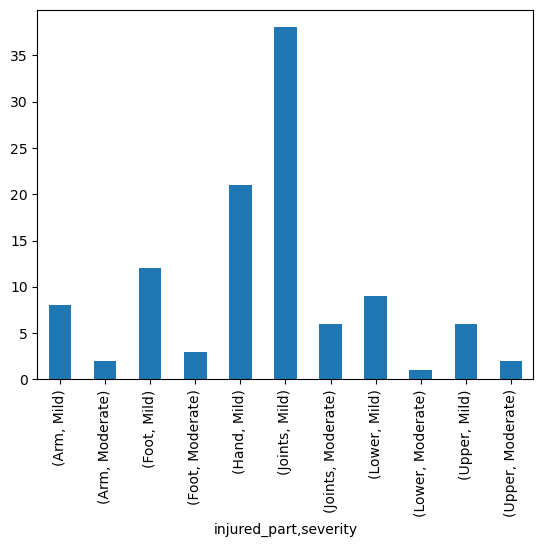

In [149]:
plot_severity_by_category('Contusion & Impact')


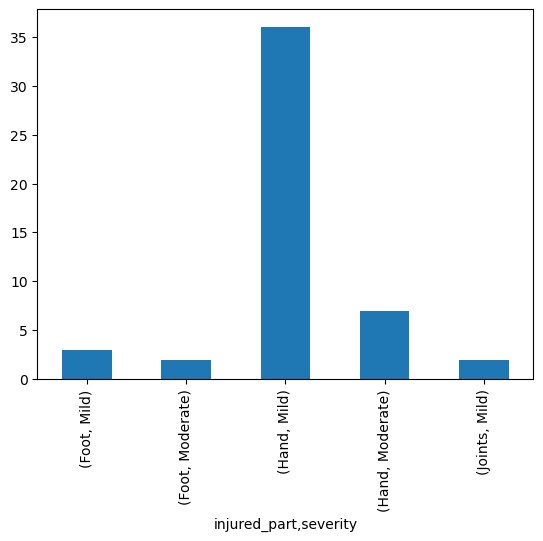

In [150]:
plot_severity_by_category('Skin')


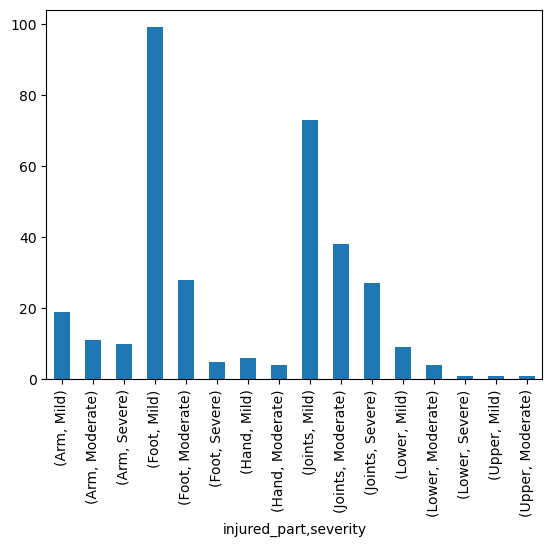

In [151]:
plot_severity_by_category('Discomfort & Tightness')     


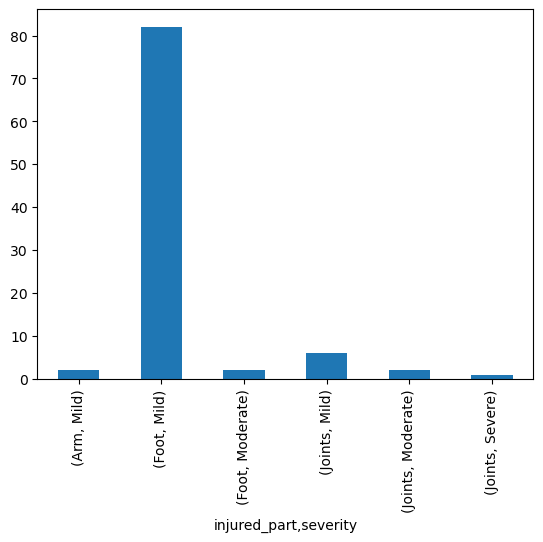

In [152]:
plot_severity_by_category('Neurological')


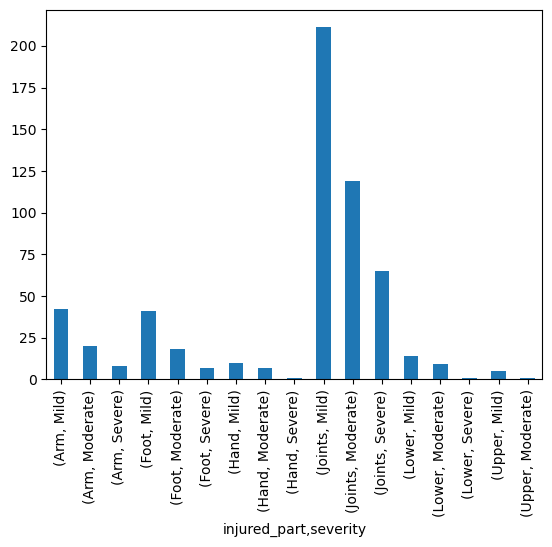

In [153]:
plot_severity_by_category('Imflammation')

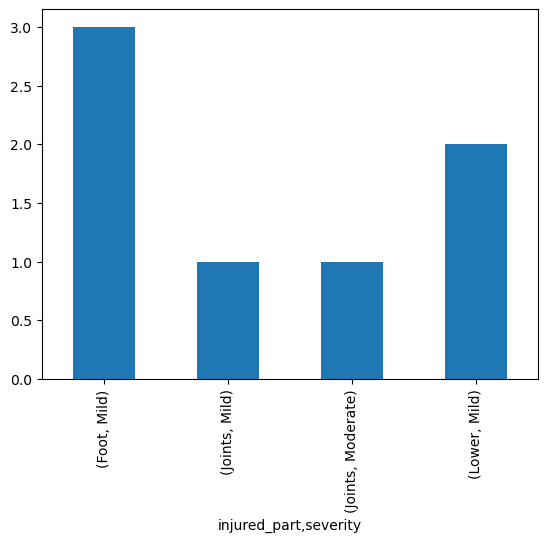

In [154]:

plot_severity_by_category('Infection')

In [155]:
def severity_counts(injury_category):
    df_category = df[df.injury_category == injury_category]
    test = df_category.loc[:, ['injured_part', 'severity']]
    return test.groupby('injured_part').value_counts()


severity_counts("Major Surgery")

injured_part  severity
Arm           Severe       18
              Moderate      2
Foot          Severe       21
              Moderate      2
Hand          Moderate     16
              Severe       16
Joints        Severe      376
              Moderate     40
              Mild         20
Lower         Severe       20
              Mild          4
              Moderate      4
Upper         Severe        5
              Moderate      3
              Mild          1
Name: count, dtype: int64

In [156]:
df_imflammation = df[df.injury_category == 'Imflammation']
df_imflammation = df_imflammation.loc[:, ['pos', 'severity', 'injured_part', 'age_at_injury']]

df_imflammation.groupby(['pos', 'severity', 'injured_part']).value_counts()


pos  severity  injured_part  age_at_injury
C    Mild      Foot          25               1
                             31               1
               Hand          24               1
               Joints        28               2
                             23               1
                                             ..
UTL  Moderate  Joints        31               1
                             33               1
                             36               1
     Severe    Joints        21               1
                             29               1
Name: count, Length: 293, dtype: int64

In [157]:
df_imflammation = df_imflammation.loc[:, ['pos', 'severity', 'injured_part', 'age_at_injury']]

df_imflammation.groupby(['pos', 'severity', 'injured_part'])['age_at_injury'].mean()


pos  severity  injured_part
C    Mild      Foot            28.000000
               Hand            24.000000
               Joints          26.800000
               Lower           36.000000
     Moderate  Joints          34.333333
                                 ...    
UTL  Mild      Joints          28.428571
               Upper           24.000000
     Moderate  Foot            24.000000
               Joints          30.285714
     Severe    Joints          25.000000
Name: age_at_injury, Length: 62, dtype: float64

In [158]:
chronic_acute_map = {
    'chronic': r'surgery|impingement|tendinopathy|\bstress fracture\b|stress|itis|inflammation|metatarsalgia|spasm|tightness|discomfort|fatigue|stiffness|soreness',
    'acute':  r'strain|sprain|fracture|bone bruise|dislocation|contusion|impact|skin|cut|laceration|blister|illness|viral|bacterial|covid|flu|infection|sepsis'
}

def categorize_injury(injury):
    injury_lower = str(injury).lower()
    for category, pattern in chronic_acute_map.items():
        if pd.Series(injury_lower).str.contains(pattern, case=False, na=False).any():
            return category
    return 'other'

df['chronic_acute'] = df['injury'].apply(categorize_injury)

df


,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category,injured_part,severity,chronic_acute
0,Robert Stephenson,1993-02-24,RP,Tommy John surgery,2024-04-30,393,31,Major Surgery,Joints,Severe,chronic
1,Zach Neto,2001-01-31,INF,Shoulder surgery,2024-11-06,163,23,Major Surgery,Joints,Severe,chronic
2,Anthony Rendon,1990-06-06,INF,Hip surgery,2025-02-01,240,34,Major Surgery,Lower,Severe,chronic
4,Yoán Moncada,1995-05-27,INF,Sprained thumb (right),2025-04-09,27,29,Ligament sprain,Hand,Mild,acute
5,Mike Trout,1991-08-07,OF,Knee contusion,2025-04-30,30,33,Contusion & Impact,Joints,Mild,acute
...,...,...,...,...,...,...,...,...,...,...,...
4453,Sam Coonrod,1992-09-22,RP,Strained shoulder,2020-09-25,3,28,Muscle strain,Joints,Mild,acute
4454,Reyes Moronta,1993-01-06,RP,Shoulder surgery (torn labrum),2019-09-10,384,26,Major Surgery,Joints,Severe,chronic
4455,Aramis Garcia,1993-01-12,C,Hip surgery,2020-02-06,235,27,Major Surgery,Lower,Severe,chronic
4456,Tyler Beede,1993-05-23,SPRP,Tommy John surgery,2020-03-20,192,26,Major Surgery,Joints,Severe,chronic


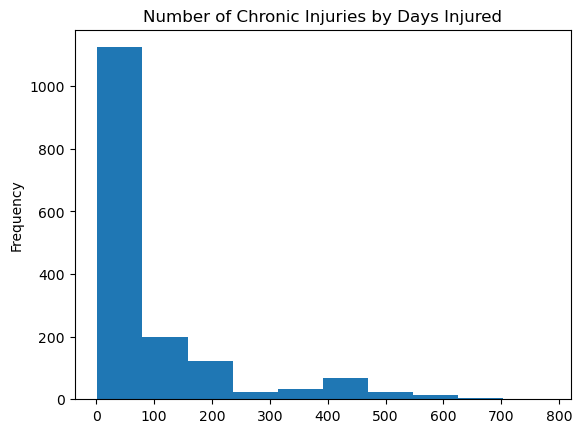

In [159]:
plt.title('Number of Chronic Injuries by Days Injured')
plt.suptitle('')
plt.xlabel('Days Injured')
plt.ylabel('Frequency')
df.loc[df['chronic_acute'] ==  'chronic']['days_injured'].plot(kind='hist')

plt.show()

Text(0, 0.5, 'Frequency')

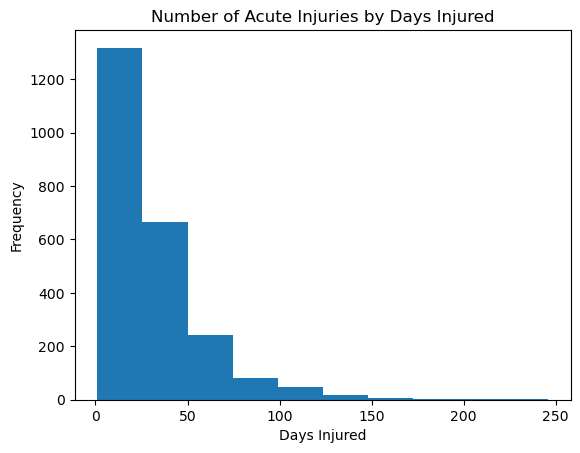

In [160]:
df.loc[df['chronic_acute'] ==  'acute']['days_injured'].plot(kind='hist')
plt.title('Number of Acute Injuries by Days Injured')
plt.suptitle('')
plt.xlabel('Days Injured')
plt.ylabel('Frequency')

In [174]:

df['log_days_injured'] = df['days_injured'].apply(lambda x: np.log10(x))
df




,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category,injured_part,severity,chronic_acute,log_days_injured
0,Robert Stephenson,1993-02-24,RP,Tommy John surgery,2024-04-30,393,31,Major Surgery,Joints,Severe,chronic,2.594393
1,Zach Neto,2001-01-31,INF,Shoulder surgery,2024-11-06,163,23,Major Surgery,Joints,Severe,chronic,2.212188
2,Anthony Rendon,1990-06-06,INF,Hip surgery,2025-02-01,240,34,Major Surgery,Lower,Severe,chronic,2.380211
4,Yoán Moncada,1995-05-27,INF,Sprained thumb (right),2025-04-09,27,29,Ligament sprain,Hand,Mild,acute,1.431364
5,Mike Trout,1991-08-07,OF,Knee contusion,2025-04-30,30,33,Contusion & Impact,Joints,Mild,acute,1.477121
...,...,...,...,...,...,...,...,...,...,...,...,...
4453,Sam Coonrod,1992-09-22,RP,Strained shoulder,2020-09-25,3,28,Muscle strain,Joints,Mild,acute,0.477121
4454,Reyes Moronta,1993-01-06,RP,Shoulder surgery (torn labrum),2019-09-10,384,26,Major Surgery,Joints,Severe,chronic,2.584331
4455,Aramis Garcia,1993-01-12,C,Hip surgery,2020-02-06,235,27,Major Surgery,Lower,Severe,chronic,2.371068
4456,Tyler Beede,1993-05-23,SPRP,Tommy John surgery,2020-03-20,192,26,Major Surgery,Joints,Severe,chronic,2.283301


In [175]:
df_pitcher = df[(df['pos'] == 'SP') | (df['pos'] == 'RP') | (df['pos'] == 'SPRP')]

df_pitcher

,name,date_of_birth,pos,injury,date_injury,days_injured,age_at_injury,injury_category,injured_part,severity,chronic_acute,log_days_injured
0,Robert Stephenson,1993-02-24,RP,Tommy John surgery,2024-04-30,393,31,Major Surgery,Joints,Severe,chronic,2.594393
6,Garrett McDaniels,1999-12-15,RP,Biceps tendinitis,2025-05-01,39,25,Imflammation,Arm,Moderate,chronic,1.591065
8,Ben Joyce,2000-09-17,RP,Shoulder surgery (torn labrum),2025-05-14,173,24,Major Surgery,Joints,Severe,chronic,2.238046
9,José Fermin,1999-03-29,RP,Elbow impingement,2025-05-14,23,26,Tendon injury,Joints,Mild,chronic,1.361728
10,José Fermin,2001-11-28,RP,Elbow impingement,2025-05-14,23,23,Tendon injury,Joints,Mild,chronic,1.361728
...,...,...,...,...,...,...,...,...,...,...,...,...
4448,Jeff Samardzija,1985-01-23,SP,Shoulder impingement,2020-08-07,49,35,Tendon injury,Joints,Moderate,chronic,1.690196
4450,Trevor Gott,1992-08-26,RP,Elbow inflammation,2020-09-09,19,28,Imflammation,Joints,Mild,chronic,1.278754
4453,Sam Coonrod,1992-09-22,RP,Strained shoulder,2020-09-25,3,28,Muscle strain,Joints,Mild,acute,0.477121
4454,Reyes Moronta,1993-01-06,RP,Shoulder surgery (torn labrum),2019-09-10,384,26,Major Surgery,Joints,Severe,chronic,2.584331


Text(0, 0.5, 'Frequency')

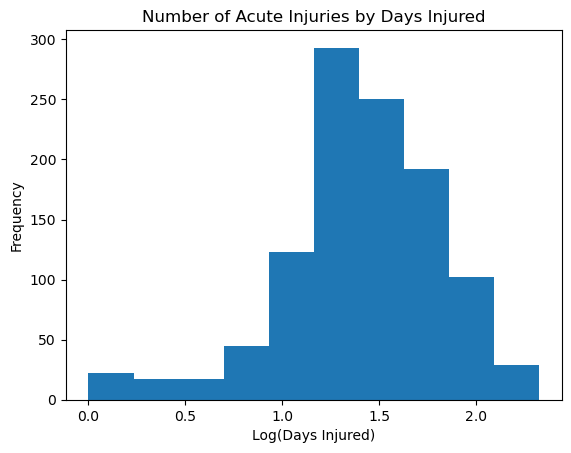

In [176]:

df_pitcher.loc[df_pitcher['chronic_acute'] ==  'acute']['log_days_injured'].plot(kind='hist')
plt.title('Number of Acute Injuries by Days Injured')
plt.suptitle('')
plt.xlabel('Log(Days Injured)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

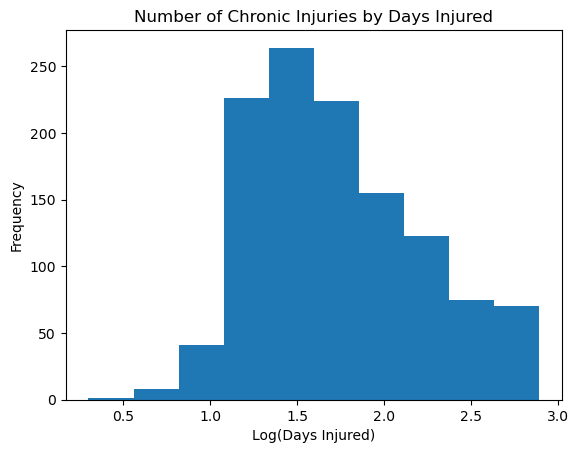

In [ ]:
df_pitcher.loc[df_pitcher['chronic_acute'] ==  'chronic']['log_days_injured'].plot(kind='hist')
plt.title('Number of Chronic Injuries by Days Injured')
plt.suptitle('')
plt.xlabel('Log(Days Injured)')
plt.ylabel('Frequency')

/var/folders/lx/xt8wcprd0z1dw0d65p11kz180000gn/T/ipykernel_80841/1608218249.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pitcher_chronic_injured_part = df_pitcher[(df_pitcher['chronic_acute'] == 'chronic') & (df['injured_part'] == injured_part)]


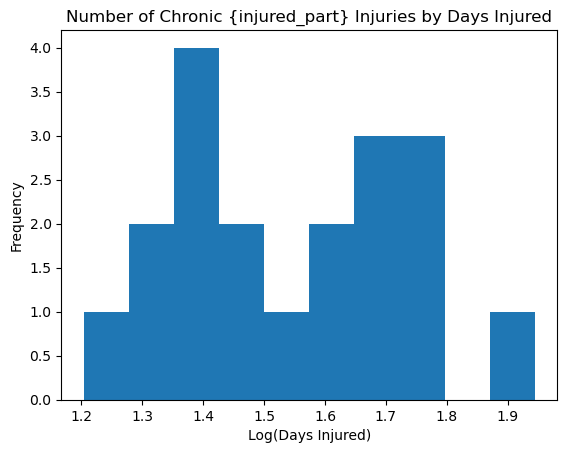

In [186]:

body_part_map = {
    'Joints' : r'shoulder|rotator cuff|scapula|teres major|thoracic|wrist|carpal|ankle|achilles|elbow|tommy john|ucl|ulnar|knee|acl|meniscus|patellar|patella',
    'Lower': r'leg|glute|gluteal|hamstring|quad|calf|shin|adductor|groin|hip|tibial|thigh',
    'Upper': r'chest|pectoral|rib|ribcage|ab|sports hernia|abdominal|oblique|abdomen|core|intercostal|costochondral',
    'Arm': r'arm|biceps|triceps|forearm|flexor',
    'Hand': r'hand|finger|nail|thumb|hamate|pinky',
    'Foot': r'|foot|toe|plantar|heel',
    'Internal': r'kidney|lung|append|col|covid|viral|flu|gastr',
    'Head/Neck' :  r'head|concussion|nasal|nose|facial|face|eye|jaw|neck|cervical',

}

def chronic_injuries_by_part(injured_part):
    df_pitcher_chronic_injured_part = df_pitcher[(df_pitcher['chronic_acute'] == 'chronic') & (df['injured_part'] == injured_part)]
    df_pitcher_chronic_injured_part['log_days_injured'].plot(kind='hist')
    plt.title('Number of Chronic {injured_part} Injuries by Days Injured')
    plt.suptitle('')
    plt.xlabel('Log(Days Injured)')
    plt.ylabel('Frequency')

chronic_injuries_by_part('Hand')


In [ ]:
# Try predicting pitchers first then expand?